https://www.kaggle.com/datasets/adrianvinueza/gym-customers-features-and-churn/data

"It's necessary to implement an effective customer retention strategy through data analysis. The main goal is to predict the probability of customer churn for the next month, identify key customer profiles, and develop specific recommendations to improve customer retention and satisfaction. This will enable optimizing the customer experience and strengthening their loyalty."

#### Variables:
- **Gender** *(assuming 0 - male, 1 - female)*.
- **Near_Location** - if the user lives or works in the neighborhood where the gym is located *(assuming 0 - no, 1 - yes)*.
- **Partner** - if the user works in an associated company (the gym has associated companies whose employees get discounts; in those cases, the gym stores information about the clients' employers) *(assuming 0 - no, 1 - yes)*.
- **Promo_friends** - if the user originally signed up through a "bring a friend" offer (they used a friend's promotional code when they paid the first subscription) *(assuming 0 - no, 1 - yes)*.
- **Phone** - if the user provided their phone number *(assuming 0 - no, 1 - yes)*.
- **Contract_period**
- **Group_visits** - *(assuming 0 - no, 1 - yes)*
- **Age**
- **Avg_additional_charges_total**
- **Month_to_end_contract**
- **Lifetime** - the time (in months) since the user first arrived at the gym.
- **Avg_class_frequency_total**
- **Avg_class_frequency_current_month**
- **Churn** - cancellation for the current month *(assuming 0 - no, 1 - yes)*.

In [844]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

sns.set_style("whitegrid")
sns.set_palette("RdBu_r")
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [845]:
df = pd.read_csv("/Users/korneliakozaczewska/Desktop/chmurka/git/projects/gym_churn_us.csv")

## Data Overview

In [846]:
df.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.22747,5.00000,3,0.02040,0.00000,0
1,0,1,0,0,1,12,1,31,113.20294,12.00000,7,1.92294,1.91024,0
2,0,1,1,0,1,1,0,28,129.44848,1.00000,2,1.85910,1.73650,0
3,0,1,1,1,1,12,1,33,62.66986,12.00000,2,3.20563,3.35721,0
4,1,1,1,1,1,1,0,26,198.36227,1.00000,3,1.11388,1.12008,0


In [847]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

In [848]:
df = df.rename(columns={"gender" : "Gender", "Near_Location" : "Near_location"})

In [849]:
df.isnull().sum() # no null values

Gender                               0
Near_location                        0
Partner                              0
Promo_friends                        0
Phone                                0
Contract_period                      0
Group_visits                         0
Age                                  0
Avg_additional_charges_total         0
Month_to_end_contract                0
Lifetime                             0
Avg_class_frequency_total            0
Avg_class_frequency_current_month    0
Churn                                0
dtype: int64

In [850]:
df.duplicated().sum() # no duplicates

0

## Exploratory Data Analysis (EDA)

In [851]:
df.describe()

,Gender,Near_location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,4000.00000,4000.00000,4000.00000,4000.00000,4000.00000,4000.00000,4000.00000,4000.00000,4000.00000,4000.00000,4000.00000,4000.00000,4000.00000,4000.00000
mean,0.51025,0.84525,0.48675,0.30850,0.90350,4.68125,0.41225,29.18425,146.94373,4.32275,3.72475,1.87902,1.76705,0.26525
std,0.49996,0.36171,0.49989,0.46193,0.29531,4.54971,0.49230,3.25837,96.35560,4.19130,3.74927,0.97224,1.05291,0.44152
min,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,18.00000,0.14820,1.00000,0.00000,0.00000,0.00000,0.00000
25%,0.00000,1.00000,0.00000,0.00000,1.00000,1.00000,0.00000,27.00000,68.86883,1.00000,1.00000,1.18088,0.96300,0.00000
50%,1.00000,1.00000,0.00000,0.00000,1.00000,1.00000,0.00000,29.00000,136.22016,1.00000,3.00000,1.83277,1.71957,0.00000
75%,1.00000,1.00000,1.00000,1.00000,1.00000,6.00000,1.00000,31.00000,210.94962,6.00000,5.00000,2.53608,2.51034,1.00000
max,1.00000,1.00000,1.00000,1.00000,1.00000,12.00000,1.00000,41.00000,552.59074,12.00000,31.00000,6.02367,6.14678,1.00000


- **Gender** - 51% of users are women.
- **Near_Location** - 84% of users live or works in the neighborhood where the gym is located.
- **Partner** - 48% of users work in an associated company.
- **Promo_friends** - 30% of users originally signed up through a "bring a friend" offer.
- **Phone** - 90% of users provided their phone number.
- **Contract_period** - average lenghts is 4.68 months.
- **Group_visits** - 41% of users did group visits.
- **Age** - average age is 29 years old.
- **Avg_additional_charges_total** - users' average is 146.
- **Month_to_end_contract** - average length is 4.32 months.
- **Lifetime** - average is 3.72 months.
- **Avg_class_frequency_total** - users' average is 1.87.
- **Avg_class_frequency_current_month** - users' average is 1.76.
- **Churn** - 26% of users want to cancel for the current month.

In [852]:
x = df.drop(columns="Churn") # all variables without churn
y = df["Churn"]
x_cy = df.drop(columns=["Age",
                       "Avg_additional_charges_total",
                       "Month_to_end_contract",
                       "Lifetime",
                       "Avg_class_frequency_total",
                       "Avg_class_frequency_current_month"],
              errors="ignore") # all categorical variables with churn
x_c = x_cy.drop(columns=["Churn"], errors="ignore") # all categorical variables without churn
x_n = x.drop(columns=x_cy.columns, errors="ignore") # all numerical variables without churn
x_ny = pd.concat([x_n, y], axis=1) # all numerical variables with churn


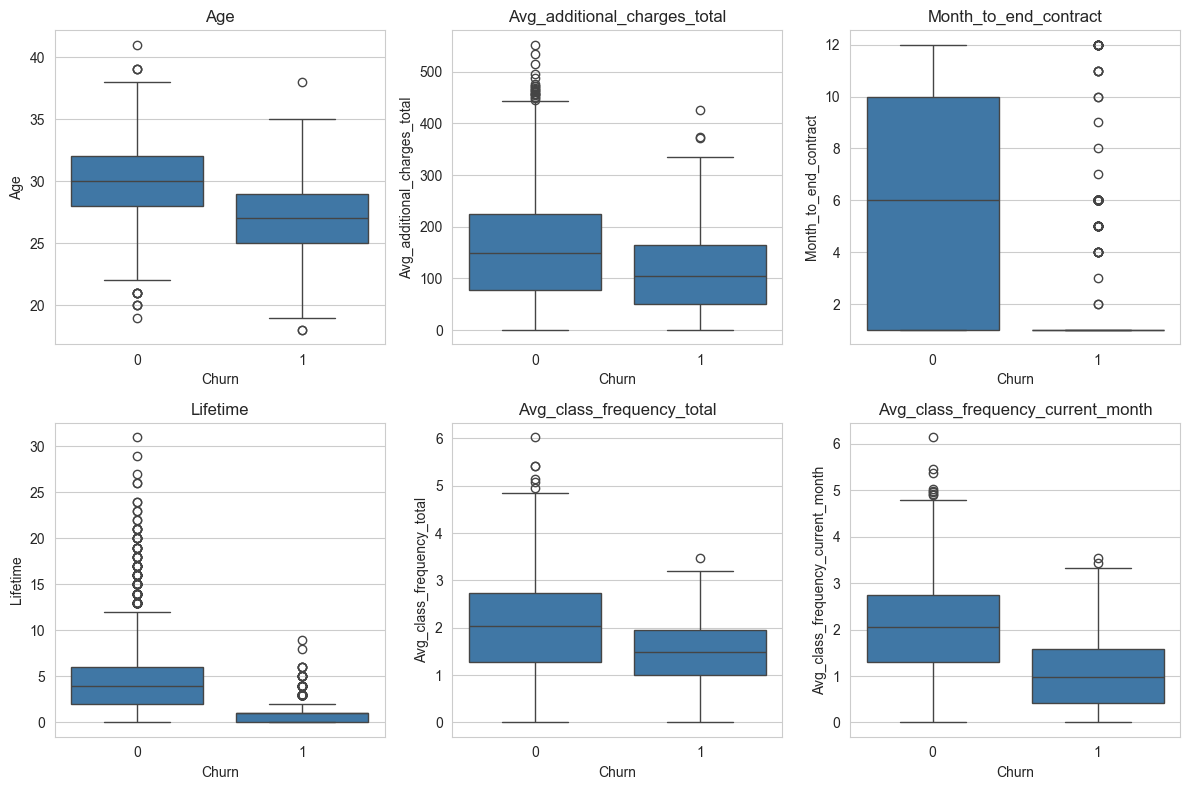

In [853]:
fig, axes = plt.subplots(2, 3, figsize=(12,8))

for ax, col in zip(axes.flat, x_n.columns):
    sns.boxplot(
        data=df, 
        x="Churn", 
        y=col,
        ax=ax,
        showfliers=True
    )
    ax.set_title(col)
    
plt.tight_layout()
plt.show()


We see that we have some outliers but they're not clustering in only one group (churned or didn't churn).

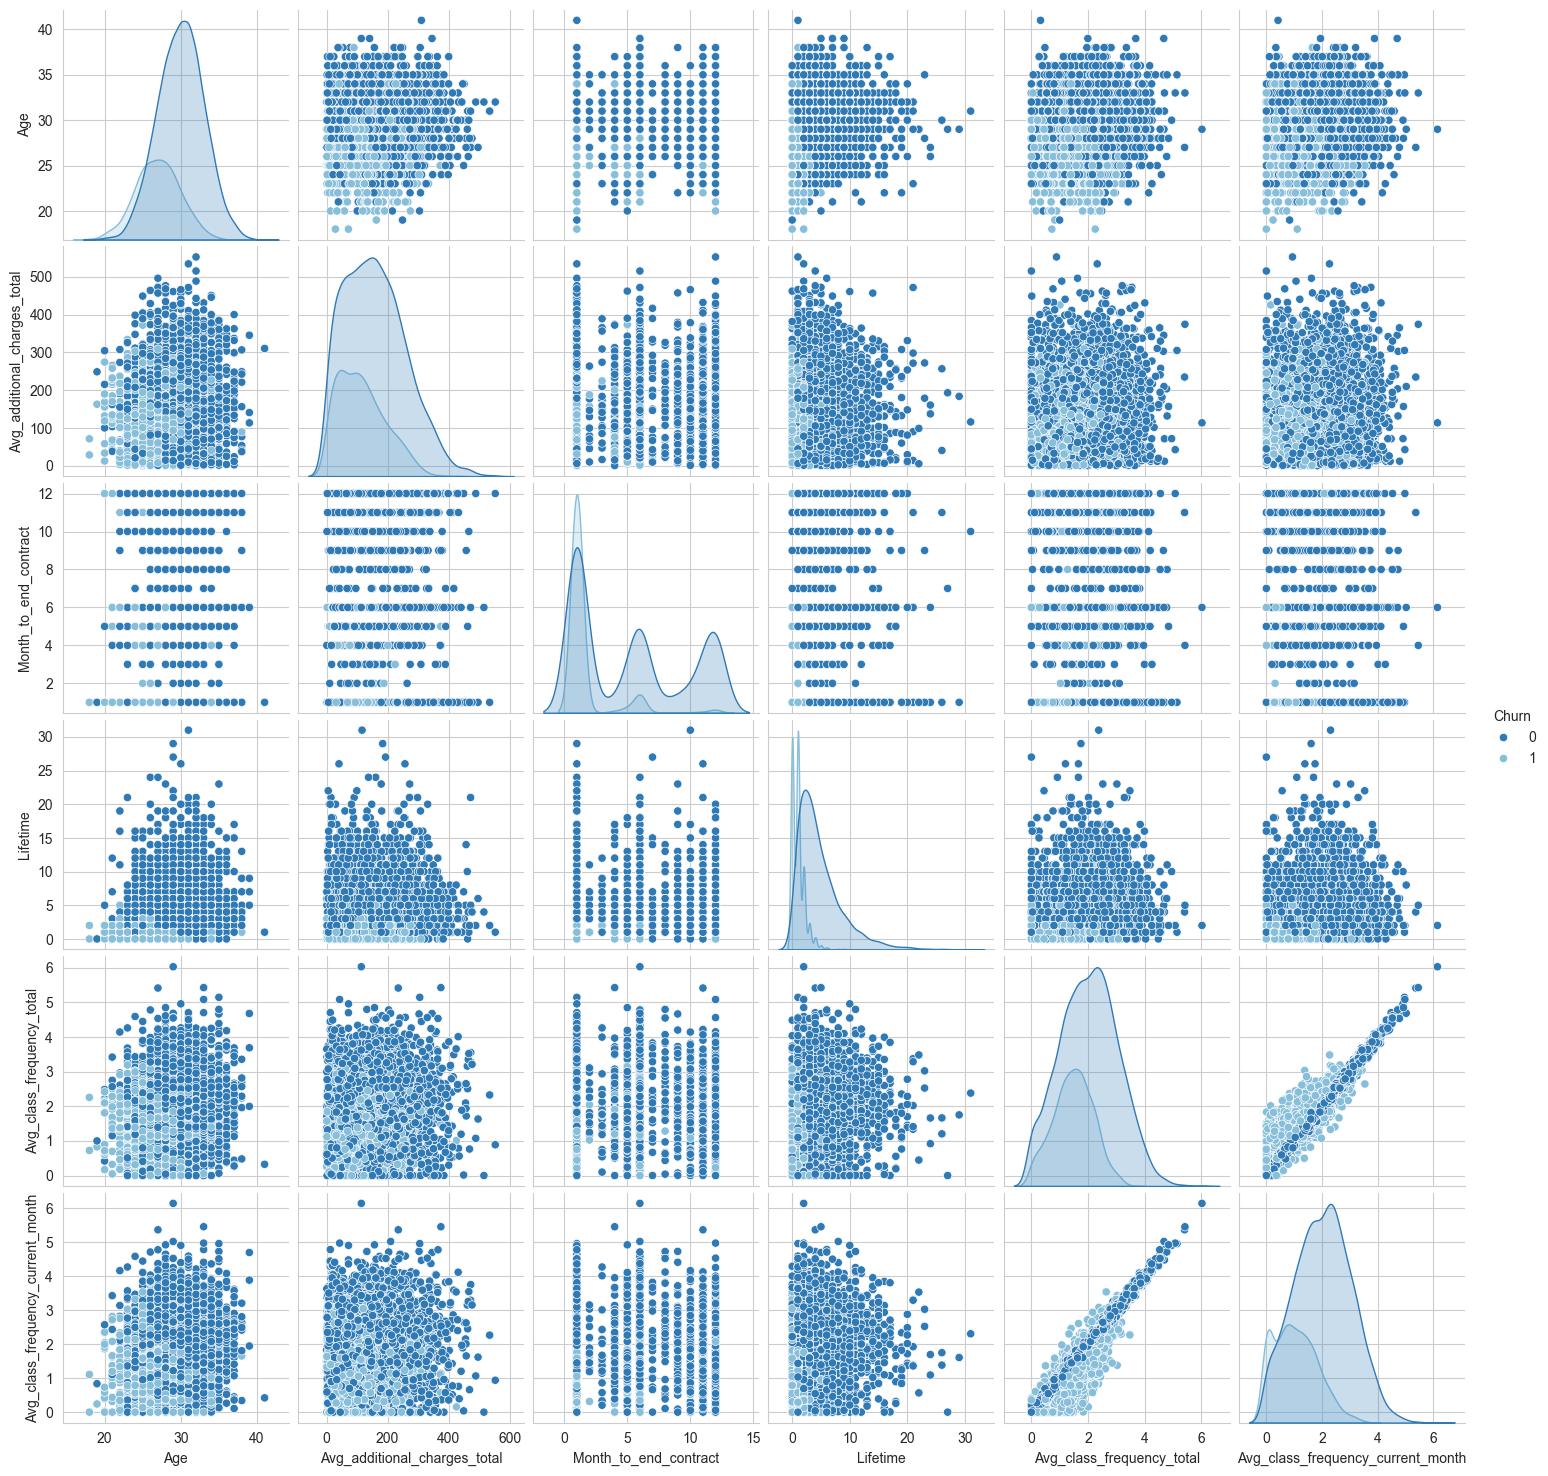

In [854]:
sns.pairplot(x_ny, hue="Churn")
plt.show()

Users that are closer to end of their contract (Month_to_end_contract) and those with shorter time since their first visit in the gym (Lifetime] seem to be more prone to churn. Younger (Age) and users with smaller average class frequency for the current month (Avg_class_frequency_current_month) as well.

There also seem to be a mild correlation between Avg_class_frequency_current_month and Avg_class_frequency_total.

## Statistical testing

In [855]:
median_by_churn = df.groupby("Churn")[x_n.columns].median().T
median_by_churn

Churn,0,1
Age,30.00000,27.00000
Avg_additional_charges_total,149.88117,103.81469
Month_to_end_contract,6.00000,1.00000
Lifetime,4.00000,1.00000
Avg_class_frequency_total,2.04325,1.49119
Avg_class_frequency_current_month,2.04670,0.97945


In [856]:
results = []
for col in x_n.columns:
    w, pvalue = stats.shapiro(df[col])
    results.append([w, pvalue])
results_df = pd.DataFrame(results, index=[x_n.columns], columns=["w", "p-value"])
results_df

,w,p-value
Age,0.99151,0.00000
Avg_additional_charges_total,0.96312,0.00000
Month_to_end_contract,0.74026,0.00000
Lifetime,0.81684,0.00000
Avg_class_frequency_total,0.99127,0.00000
Avg_class_frequency_current_month,0.98250,0.00000


Data is not normally distributed (p-value < .05 for all variables) so we use Mann-Whitney U test to compare medians in independent groups with Bonferroni correction for the number of tests.

In [857]:
results = []
for col in x_n.columns:
    g0 = df.loc[df["Churn"] == 0, col]
    g1 = df.loc[df["Churn"] == 1, col]
    stat, pvalue = stats.mannwhitneyu(x=g0, y=g1, alternative="two-sided")
    results.append([stat, pvalue])
results_df = pd.DataFrame(results, index=[x_n.columns], columns=["stat", "p-value"])
results_df

,stat,p-value
Age,2374707.50000,0.00000
Avg_additional_charges_total,1949479.00000,0.00000
Month_to_end_contract,2295553.00000,0.00000
Lifetime,2737108.00000,0.00000
Avg_class_frequency_total,2075227.00000,0.00000
Avg_class_frequency_current_month,2416199.00000,0.00000


Results from the Mann–Whitney U tests indicate that the medians of all examined variables differ significantly between the retained and churned groups. In particular, users who ended up churning tend to have:
- fewer months remaining on their contract,
- shorter customer lifetime (time since their first visit),
- younger age,
- and lower average class frequency in the current month.

This that not necessarily mean that other variables don't statistically differ between groups, but those seem to differ the most. Also, these associations don't imply that any of those factors directly cause churn (only likelihood is higher in users with these characteristics).

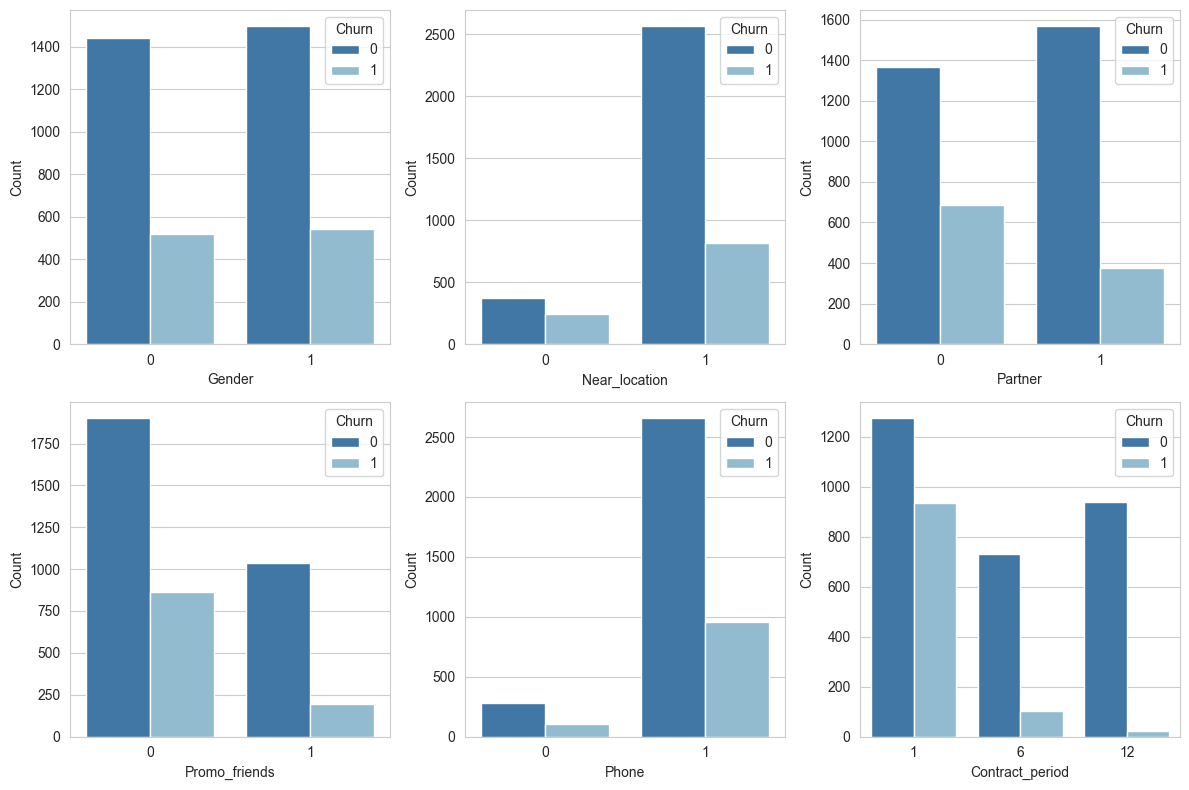

In [858]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

for ax, col in zip(axes.flat, x_c):
    sns.countplot(
        data=x_cy,
        x=col,
        hue="Churn",
        ax=ax,
        dodge=True,
    )
    ax.set_ylabel("Count")
    ax.set_xlabel(col)

plt.tight_layout()
plt.show()


Users with the gym nearby (Near_location), who work in associated company (Partner), who provided their phone number (Phone) and those with shorter contract period (Contract_period) seem to be more likely to churn. We'll check that with the Chi-Squared test.

In [859]:
results = []
for col in x_c.columns:
    table = pd.crosstab(df[col], df["Churn"])
    chi2, p, dof, expected = stats.chi2_contingency(table)
    results.append([chi2, p, dof, expected])
results_df = pd.DataFrame(results, index=x_c.columns, columns=["chi2", "p-value", "df", "expected"])
results_df

,chi2,p-value,df,expected
Gender,0.00008,0.99287,1,"[[1439.37525, 519.62475], [1499.62475, 541.375..."
Near_location,64.83653,0.00000,1,"[[454.81025, 164.18975], [2484.18975, 896.81025]]"
Partner,99.12327,0.00000,1,"[[1508.44175, 544.55825], [1430.55825, 516.441..."
Promo_friends,104.48415,0.00000,1,"[[2032.3185, 733.6815], [906.6815, 327.3185]]"
Phone,0.00019,0.98902,1,"[[283.6135, 102.3865], [2655.3865, 958.6135]]"
Contract_period,653.55522,0.00000,2,"[[1621.59325, 585.40675], [612.04675, 220.9532..."
Group_visits,122.14946,0.00000,1,"[[1727.39725, 623.60275], [1211.60275, 437.397..."


Chi-Squared tests indicate that all categorical variables, except "Gender" and "Phone", show statistically significant differences in churned and non-churned groups. The strongest difference can be found in the length of the contract period.

Now, we'll see how much information about our users (churned vs non-churned) we can get from each variable.

## Entropy

In [860]:
probs = df["Churn"].value_counts(normalize=True)
H_parent = stats.entropy(probs, base=2) # entropy of the whole dataset
H_parent

0.8345658024116291

In [861]:
results = []
for col in x_c.columns:
    table = pd.crosstab(x[col], df["Churn"])
    cond_probs = table.div(table.sum(axis=1), axis=0) # dividing each element by sum for X == x (cond_prob for X)
    H_children = cond_probs.apply(lambda row: stats.entropy(row, base=2), axis=1) # H(Churn | X == x)
    weights = table.sum(axis=1) / table.values.sum() # p(X == x) for whole dataset
    H_cond = (weights * H_children).sum()
    IG = H_parent - H_cond
    results.append(IG)
results_c_df = pd.DataFrame(results, columns=["Information gain"], index=[x_c.columns])

results = []
for col in x_n.columns:
    bins = pd.cut(df[col], bins=2) # splitting numerical data into two categories
    table = pd.crosstab(bins, df["Churn"])
    cond_prob = table.div(table.sum(axis=1), axis=0)
    H_children = cond_probs.apply(lambda row: stats.entropy(row, base=2), axis=1)
    weights = table.sum(axis=1) / table.values.sum()
    H_cond = (weights * H_children).sum()
    IG = H_parent - H_cond
    results.append(IG)
results_n_df = pd.DataFrame(results, columns=["Information gain"], index=[x_n.columns])

results_df = pd.concat([results_c_df, results_n_df], axis=0)
results_df.sort_values(by="Information gain", ascending=False)

,Information gain
Age,0.83457
Avg_additional_charges_total,0.83457
Month_to_end_contract,0.83457
Lifetime,0.83457
Avg_class_frequency_total,0.83457
Avg_class_frequency_current_month,0.83457
Contract_period,0.13998
Group_visits,0.02298
Promo_friends,0.02028
Partner,0.01823


Based on the information gain each variable provided us with, we see that Age, Avg_additional_charges_total, Month_to_end_contract, Lifetime, Avg_class_frequency_total, and Avg_class_frequency_current_month are the strongest predictors of churn in this dataset. Moreover, their IG seems to be equal to H_parent, meaning that knowing the value of any of those variables removes all uncertainty whether the user will churn in the current month or not.

Phone and Gender bring almost no information (which was confirmed by Chi-Squared tests). We'll be dropping those two variables in the next steps.

## Data preprocessing

First, we will be splitting data into training, validation, and test subsets.

In [862]:
# train ratio is 75%, validation ratio is 15% and test ratio is 10%
x_train, x_test, y_train, y_test = train_test_split(
    x, y,
    test_size=.2, random_state=123
) 
x_val, x_test, y_val, y_test = train_test_split(
    x_test, y_test,
    test_size=.25, random_state=123
) # 0.25 * 0.8 = 0.2

In [863]:
x_train_n = x_train.drop(columns=x_c.columns, errors="ignore")
x_train_c = x_train.drop(columns=x_n.columns, errors="ignore")

x_test_n = x_test.drop(columns=x_c.columns, errors="ignore")
x_test_c = x_test.drop(columns=x_n.columns, errors="ignore")

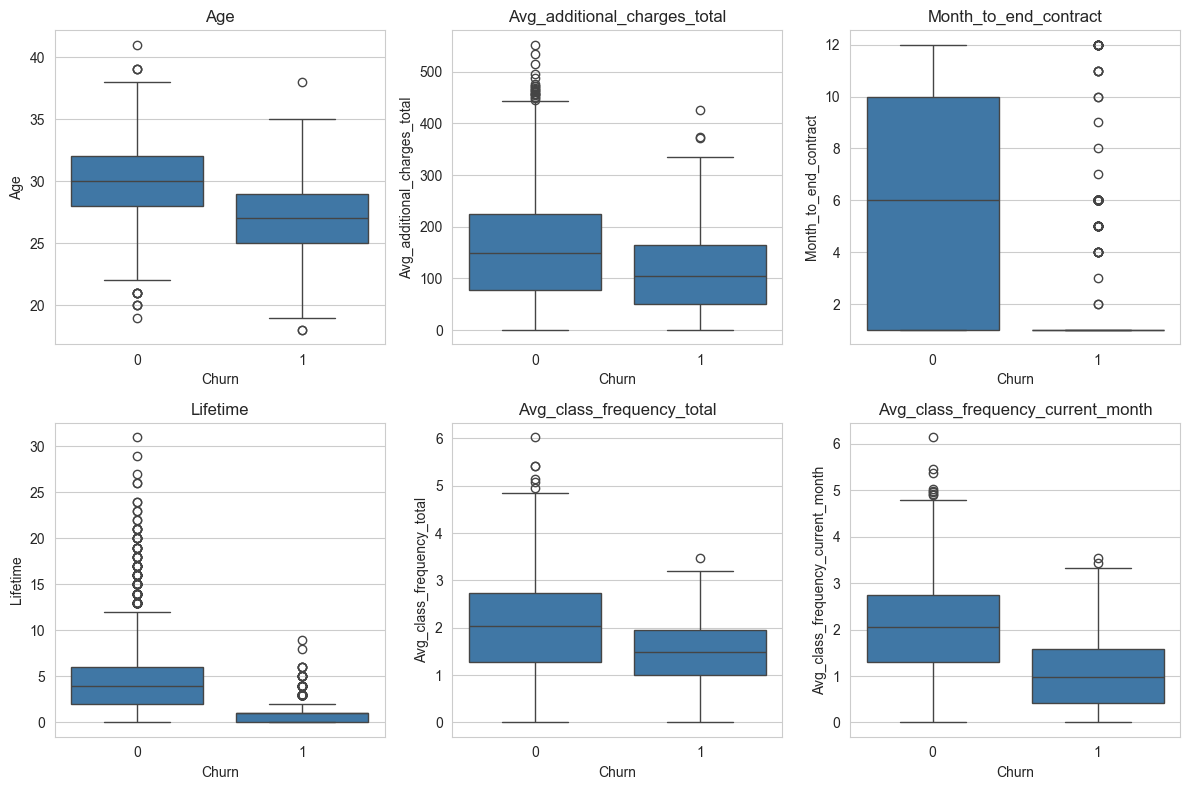

In [864]:
fig, axes = plt.subplots(2, 3, figsize=(12,8))

for ax, col in zip(axes.flat, x_train_n.columns):
    sns.boxplot(
        data=df, 
        x="Churn", 
        y=col,
        ax=ax,
        showfliers=True
    )
    ax.set_title(col)
    
plt.tight_layout()
plt.show()

For feature scaling, we will standardize the data (train and test); however, first, we need to address the outliers present in the data. We're going to leave them since they don't seem to be of error origin. Then the robust scaling technique will be used to deal with them.

In [865]:
transformer = RobustScaler()

x_train_n_scaled = transformer.fit_transform(x_train_n)
x_train_n_scaled = pd.DataFrame(data=x_train_n_scaled, columns=x_n.columns, index=x_train_n.index)
x_train_scaled = pd.concat([x_train_c, x_train_n_scaled], axis=1)

x_test_n_scaled = transformer.transform(x_test_n)
x_test_n_scaled = pd.DataFrame(data=x_test_n_scaled, columns=x_n.columns, index=x_test_n.index)
x_test_scaled = pd.concat([x_test_c, x_test_n_scaled], axis=1)

## Logistic regression

In [866]:
lr = LogisticRegression(random_state=123)
lr.fit(x_train_scaled, y_train)

y_pred_lr = lr.predict(x_test_scaled)

In [867]:
cnf_matrix_lr = confusion_matrix(y_test, y_pred_lr)
cnf_matrix_lr

array([[137,  11],
       [ 10,  42]])

Text(0.5, 427.9555555555555, 'Predicted')

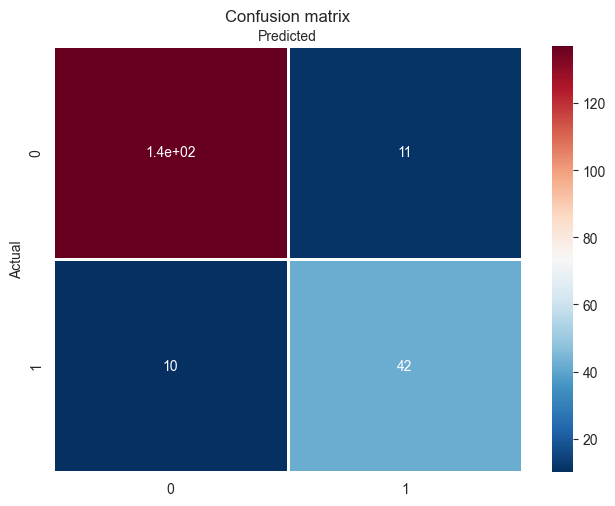

In [868]:
class_names = [0,1]

fig, ax = plt.subplots()

tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

sns.heatmap(pd.DataFrame(cnf_matrix_lr), annot=True, linewidths=1, cmap="RdBu_r" )
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title("Confusion matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")

In [869]:
target_names = ["didn't churn", "churned"]
print(classification_report(y_test, y_pred_lr, target_names=target_names))

              precision    recall  f1-score   support

didn't churn       0.93      0.93      0.93       148
     churned       0.79      0.81      0.80        52

    accuracy                           0.90       200
   macro avg       0.86      0.87      0.86       200
weighted avg       0.90      0.90      0.90       200



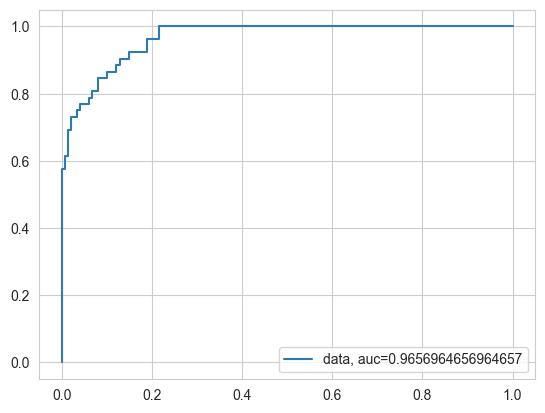

In [870]:
y_pred_proba_lr = lr.predict_log_proba(x_test_scaled)[::,1]
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba_lr)
auc_lr = roc_auc_score(y_test, y_pred_proba_lr)

plt.plot(fpr_lr, tpr_lr, label="data, auc="+str(auc_lr))
plt.legend(loc=4)
plt.show()

## KNN Classifier

First, we're going to check which number of neighbours brings us the highest accuracy score.

In [871]:
k_values = [i for i in range(1,31)]
scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, algorithm="auto")
    knn.fit(x_train_scaled, y_train)
    distances, indices = knn.kneighbors(x_train_scaled)
    score = cross_val_score(knn, x_train_scaled, y_train)
    scores.append(np.mean(score))

y_pred_knn = knn.predict(x_test)

Text(0, 0.5, 'Accuracy score')

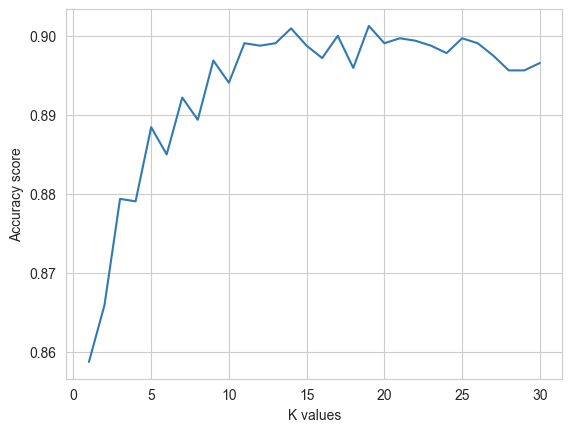

In [872]:
sns.lineplot(x = k_values, y = scores, markers="o")
plt.xlabel("K values")
plt.ylabel("Accuracy score")

We can see that the core is riring up until 11th value, with the highest at 14th, so the numbers of neighbours in our model is going to be 14.

In [873]:
knn = KNeighborsClassifier(n_neighbors=14, algorithm="auto")
knn.fit(x_train_scaled, y_train)
distances, indices = knn.kneighbors(x_train_scaled)

y_pred_knn = knn.predict(x_test)

In [874]:
cnf_matrix_knn = confusion_matrix(y_test, y_pred_knn)
cnf_matrix_knn

array([[148,   0],
       [ 52,   0]])

Text(0.5, 427.9555555555555, 'Predicted')

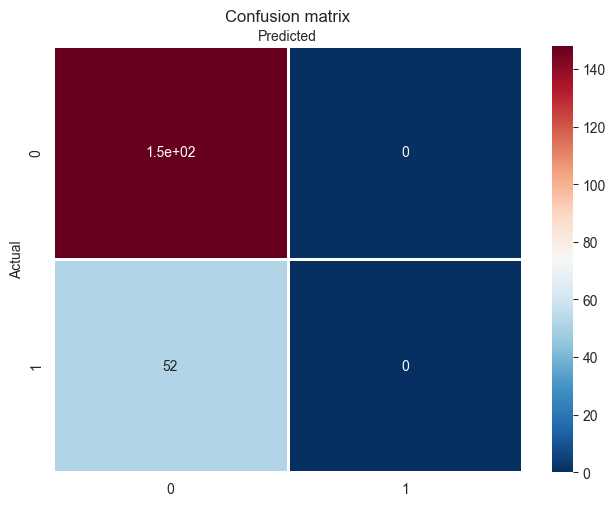

In [875]:
fig, ax = plt.subplots()

tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

sns.heatmap(pd.DataFrame(cnf_matrix_knn), annot=True, linewidths=1, cmap="RdBu_r")
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title("Confusion matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")

In [876]:
print(classification_report(y_test, y_pred_knn, target_names=target_names))

              precision    recall  f1-score   support

didn't churn       0.74      1.00      0.85       148
     churned       0.00      0.00      0.00        52

    accuracy                           0.74       200
   macro avg       0.37      0.50      0.43       200
weighted avg       0.55      0.74      0.63       200



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beha

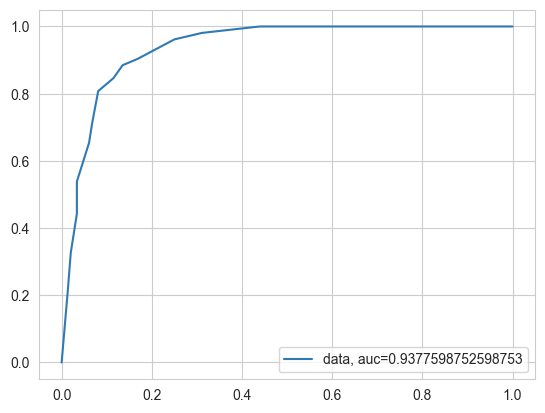

In [877]:
y_pred_proba_knn = knn.predict_proba(x_test_scaled)[::,1]
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_pred_proba_knn)
auc_knn = roc_auc_score(y_test, y_pred_proba_knn)

plt.plot(fpr_knn, tpr_knn, label="data, auc="+str(auc_knn))
plt.legend(loc=4)
plt.show()

## Random Forest

Apart from logistic regression and KNN, random forest don't require scaling the data before hand.

In [878]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(x_train, y_train)
y_pred_rf = rf.predict(x_test)

In [879]:
cnf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
cnf_matrix_rf

array([[138,  10],
       [ 11,  41]])

Text(0.5, 427.9555555555555, 'Predicted')

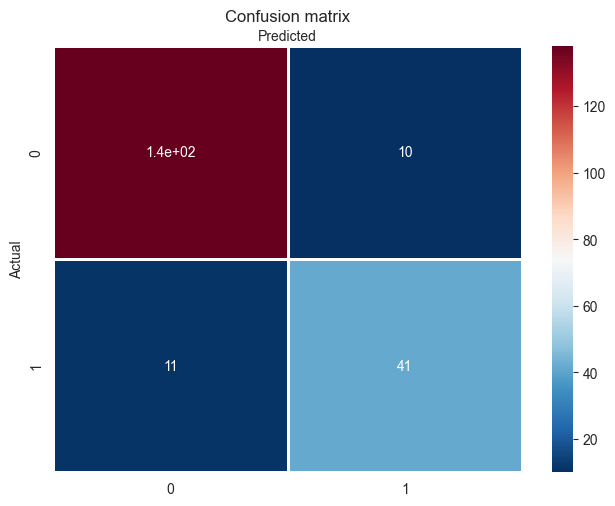

In [880]:
fig, ax = plt.subplots()

tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

sns.heatmap(pd.DataFrame(cnf_matrix_rf), annot=True, linewidths=1, cmap="RdBu_r")
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title("Confusion matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")

In [881]:
print(classification_report(y_test, y_pred_rf, target_names=target_names))

              precision    recall  f1-score   support

didn't churn       0.93      0.93      0.93       148
     churned       0.80      0.79      0.80        52

    accuracy                           0.90       200
   macro avg       0.87      0.86      0.86       200
weighted avg       0.89      0.90      0.89       200



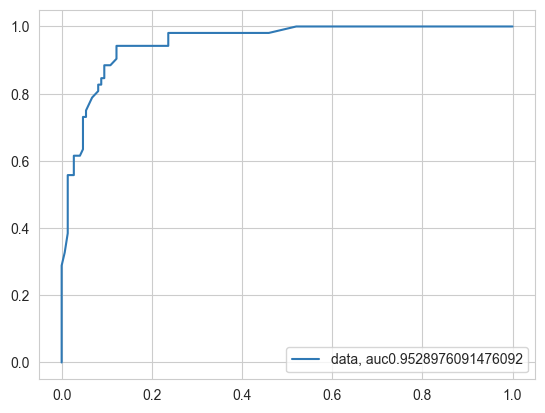

In [883]:
y_pred_proba_rf = rf.predict_proba(x_test)[::,1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)
auc_rf = roc_auc_score(y_test, y_pred_proba_rf)

plt.plot(fpr_rf, tpr_rf, label="data, auc"+str(auc_rf))
plt.legend(loc=4)
plt.show()

## Gradient Boosting Classifier